# **Frame Scorer Benchmark**

## **Strategies Tested**
1. **CLIP Scoring** - Question-Frame Similarity using OpenAI CLIP (*ViT-L/14 and ViT-B/32*)
2. **Multilingual CLIP** - Direct Vietnamese support
3. **Detection Scoring** - YOLO-based object detection boost
4. **Distinctiveness** - Inter-Frame Distinctiveness (IFD)
5. **Combined Scoring** - Weighted combination ($\alpha$ $\cdot$ QFS + $\beta$ $\cdot$ DGS + $\gamma$ $\cdot$ IFD)

## **Metrics Tracked**
- Model initialization time
- Inference time per frame
- Memory usage
- Score quality/distribution

## **Setup**

In [59]:
import sys
import os
import time
import gc
import psutil
import warnings
from pathlib import Path
from typing import List, Dict, Any, Optional
from dataclasses import dataclass, field

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import cv2

sys.path.insert(0, '..')

warnings.filterwarnings('ignore')
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette('husl')

from src.perception.frame_scorer import (
    FrameScorer,
    ScoringConfig,
    FrameScore,
    CLIPScoringStrategy,
    MultilingualCLIPScoringStrategy,
    DetectionScoringStrategy,
    DistinctivenessStrategy,
    get_available_strategies,
    create_scorer,
)

from config.settings import get_path_config
from src.perception.query_analyzer import QueryAnalyzer
from src.perception.model_registry import ModelRegistry, get_model

print(f"Available strategies: {get_available_strategies()}")
print(f"Available YOLO models: {ModelRegistry.list_models()}")

Available strategies: ['clip', 'mclip', 'detection', 'combined']
Available YOLO models: ['yolo11n_road_lane', 'yolo11n_bdd100k', 'yolo11l_road_lane', 'yolo11l_bdd100k', 'yolo11n_unified', 'yolo11l_unified']


## **Data Preparation**

In [60]:
paths = get_path_config()
train_videos_dir = paths.train_videos_dir
video_files = list(train_videos_dir.glob("*.mp4"))[:3]

TEST_VIDEO = str(video_files[1])
print(f"Using test video: {Path(TEST_VIDEO).name}")

Using test video: 00af5b3a_305_clip_003_0012_0018_N.mp4


In [61]:
def extract_frames(video_path: str, num_frames: int = 16) -> List[np.ndarray]:
    """Extract frames uniformly from video."""
    cap = cv2.VideoCapture(video_path)
    total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
    
    # Sample uniformly
    indices = np.linspace(0, total_frames - 1, num_frames, dtype=int)
    
    frames = []
    for idx in indices:
        cap.set(cv2.CAP_PROP_POS_FRAMES, idx)
        ret, frame = cap.read()
        if ret:
            # Convert BGR to RGB
            frame_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
            frames.append(frame_rgb)
    
    cap.release()
    return frames

# Extract test frames
TEST_FRAMES = extract_frames(TEST_VIDEO, num_frames=16)
print(f"Extracted {len(TEST_FRAMES)} frames")
print(f"Frame shape: {TEST_FRAMES[0].shape}")

Extracted 16 frames
Frame shape: (1440, 2560, 3)


In [62]:
# Test questions (Vietnamese)
TEST_QUESTIONS = [
    "Biển báo tốc độ tối đa là bao nhiêu?",
    "Có đèn đỏ trong video không?",
    "Xe có được phép rẽ trái không?",
    "Có bao nhiêu làn đường?",
    "Biển cấm nào xuất hiện trong video?",
]

# Use query analyzer to get target objects
analyzer = QueryAnalyzer(strategy="keyword")

print("Test Questions with Target Objects")

for i, q in enumerate(TEST_QUESTIONS):
    result = analyzer.analyze(q)
    print(f"\n{i+1}. {q}")
    print(f"   Target Objects: {result.target_objects}")
    print(f"   YOLO Classes: {result.yolo_classes}")

Test Questions with Target Objects

1. Biển báo tốc độ tối đa là bao nhiêu?
   Target Objects: ['speed_limit_sign', 'max_speed_sign', 'traffic_sign']
   YOLO Classes: ['traffic sign']

2. Có đèn đỏ trong video không?
   Target Objects: ['traffic_light_red', 'red_light']
   YOLO Classes: ['traffic light']

3. Xe có được phép rẽ trái không?
   Target Objects: ['left_turn', 'direction_left']
   YOLO Classes: ['traffic sign']

4. Có bao nhiêu làn đường?
   Target Objects: ['lane_marking', 'lane']
   YOLO Classes: ['road']

5. Biển cấm nào xuất hiện trong video?
   Target Objects: ['prohibitory_sign']
   YOLO Classes: ['traffic sign']


## **Benchmark Utilities**

In [63]:
@dataclass
class BenchmarkResult:
    """Result from benchmarking a scorer."""
    strategy_name: str
    model_name: str = ""
    init_time_ms: float = 0.0
    avg_inference_ms: float = 0.0
    total_inference_ms: float = 0.0
    memory_mb: float = 0.0
    avg_score: float = 0.0
    score_std: float = 0.0
    min_score: float = 0.0
    max_score: float = 0.0
    scores: np.ndarray = field(default_factory=lambda: np.array([]))
    success: bool = True
    error: str = ""


def get_memory_mb(stable: bool = True) -> float:
    """Get current process memory in MB.
    
    Args:
        stable: If True, force garbage collection and wait briefly
                for more accurate measurement.
    """
    if stable:
        gc.collect()
        time.sleep(0.1)  # Allow GC to complete and memory to stabilize
    
    return psutil.Process().memory_info().rss / (1024 * 1024)
def measure_memory_delta(func, *args, **kwargs):
    """Measure memory delta from running a function.
    
    Returns:
        Tuple of (result, memory_delta_mb)
    """
    gc.collect()
    time.sleep(0.1)
    mem_before = psutil.Process().memory_info().rss / (1024 * 1024)
    
    result = func(*args, **kwargs)
    
    gc.collect()  # Don't collect here - we want to measure actual memory used
    mem_after = psutil.Process().memory_info().rss / (1024 * 1024)
    
    # Memory can fluctuate, use max(0, delta) to avoid confusing negative values
    memory_delta = max(0.0, mem_after - mem_before)
    
    return result, memory_delta

all_results: List[BenchmarkResult] = []

In [64]:
def visualize_frames_with_scores(
    frames: List[np.ndarray],
    scores: np.ndarray,
    question: str = "",
    model_name: str = "CLIP",
    top_k: Optional[int] = None,
    cols: int = 4,
    figsize_per_frame: tuple = (3, 3),
    highlight_top: int = 3,
    show_ranking: bool = True,
) -> None:
    """Visualize frames with their corresponding scores.
    
    Args:
        frames: List of RGB frames (numpy arrays)
        scores: Array of scores corresponding to each frame
        question: The question used for scoring
        model_name: Name of the model used
        top_k: If set, only show top_k frames by score
        cols: Number of columns in the grid
        figsize_per_frame: Size per frame subplot
        highlight_top: Number of top frames to highlight with green border
        show_ranking: Whether to show ranking number on each frame
    """
    # Ensure scores is a numpy array
    scores = np.array(scores)
    
    # Get sorted indices by score (descending)
    sorted_indices = np.argsort(scores)[::-1]
    
    # If top_k is set, only show top_k frames
    if top_k is not None:
        display_indices = sorted_indices[:top_k]
    else:
        display_indices = range(len(frames))
    
    n_frames = len(display_indices)
    rows = (n_frames + cols - 1) // cols
    
    fig, axes = plt.subplots(
        rows, cols,
        figsize=(cols * figsize_per_frame[0], rows * figsize_per_frame[1])
    )
    
    # Handle title
    title = f"{model_name} Frame Scores"
    if question:
        title += f"\nQ: {question[:60]}..." if len(question) > 60 else f"\nQ: {question}"
    fig.suptitle(title, fontsize=12, fontweight='bold', y=1.02)
    
    # Flatten axes for easy iteration
    if rows == 1:
        axes = axes if cols > 1 else [axes]
    axes = np.array(axes).flatten()
    
    # Get top indices for highlighting
    top_indices_set = set(sorted_indices[:highlight_top])
    
    for i, frame_idx in enumerate(display_indices):
        ax = axes[i]
        
        if frame_idx < len(frames):
            frame = frames[frame_idx]
            score = scores[frame_idx]
            
            # Find ranking for this frame
            rank = np.where(sorted_indices == frame_idx)[0][0] + 1
            
            ax.imshow(frame)
            
            # Highlight top frames with colored border
            if frame_idx in top_indices_set:
                for spine in ax.spines.values():
                    spine.set_edgecolor('lime')
                    spine.set_linewidth(4)
            else:
                for spine in ax.spines.values():
                    spine.set_edgecolor('gray')
                    spine.set_linewidth(1)
            
            # Build title
            frame_title = f"Frame {frame_idx}\nScore: {score:.3f}"
            if show_ranking:
                frame_title = f"#{rank} | " + frame_title
            
            ax.set_title(frame_title, fontsize=9)
            ax.set_xticks([])
            ax.set_yticks([])
    
    # Hide empty subplots
    for i in range(n_frames, len(axes)):
        axes[i].axis('off')
    
    plt.tight_layout()
    plt.show()
    
    # Print summary statistics
    print(f"  Total frames: {len(frames)}")
    print(f"  Score range: [{scores.min():.3f}, {scores.max():.3f}]")
    print(f"  Mean score: {scores.mean():.3f} +- {scores.std():.3f}")

## **1. CLIP Scoring Strategy Benchmark**

Testing OpenAI CLIP models for Question-Frame Similarity (QFS)

In [65]:
CLIP_MODELS = [
    "ViT-B/32",
    "ViT-L/14",
]

clip_results = []
test_question = TEST_QUESTIONS[0]

for model_name in CLIP_MODELS:
    print(f"Testing CLIP model: {model_name}")
    
    gc.collect()
    mem_before = get_memory_mb()
    scorer = None
    
    try:
        # Initialize
        init_start = time.perf_counter()
        scorer = CLIPScoringStrategy(
            model_name=model_name,
            device="cpu",
            use_translation=True
        )
        init_time = (time.perf_counter() - init_start) * 1000
        
        mem_after = get_memory_mb()
        memory_used = max(0.0, mem_after - mem_before)
        
        print(f"  Init time: {init_time:.2f} ms")
        print(f"  Memory: {memory_used:.1f} MB")
        
        # Warmup
        _ = scorer.score(TEST_FRAMES[:2], test_question)
        
        # Benchmark inference
        inference_times = []
        all_scores = []
        
        for q in TEST_QUESTIONS:
            start = time.perf_counter()
            scores = scorer.score(TEST_FRAMES, q)
            elapsed = (time.perf_counter() - start) * 1000
            inference_times.append(elapsed)
            all_scores.append(scores)
        
        avg_scores = np.mean([s.mean() for s in all_scores])
        avg_time = np.mean(inference_times)
        
        result = BenchmarkResult(
            strategy_name="clip",
            model_name=model_name,
            init_time_ms=init_time,
            avg_inference_ms=avg_time,
            total_inference_ms=sum(inference_times),
            memory_mb=memory_used,
            avg_score=avg_scores,
            score_std=np.std([s.mean() for s in all_scores]),
            min_score=np.min([s.min() for s in all_scores]),
            max_score=np.max([s.max() for s in all_scores]),
            scores=all_scores[0],
            success=True
        )
        
        print(f"  Avg inference: {avg_time:.2f} ms for {len(TEST_FRAMES)} frames")
        print(f"  Per-frame time: {avg_time/len(TEST_FRAMES):.2f} ms")
        print(f"  Avg score: {avg_scores:.3f}")
        
        clip_results.append(result)
        all_results.append(result)
        
    except Exception as e:
        print(f"Error: {e}")
        clip_results.append(BenchmarkResult(
            strategy_name="clip",
            model_name=model_name,
            success=False,
            error=str(e)
        ))
    
    # Clean up
    del scorer
    gc.collect()

Testing CLIP model: ViT-B/32
  Init time: 2312.36 ms
  Memory: 2.0 MB
  Avg inference: 2676.64 ms for 16 frames
  Per-frame time: 167.29 ms
  Avg score: 0.475
Testing CLIP model: ViT-L/14
  Init time: 11924.70 ms
  Memory: 0.0 MB
  Avg inference: 15849.92 ms for 16 frames
  Per-frame time: 990.62 ms
  Avg score: 0.441


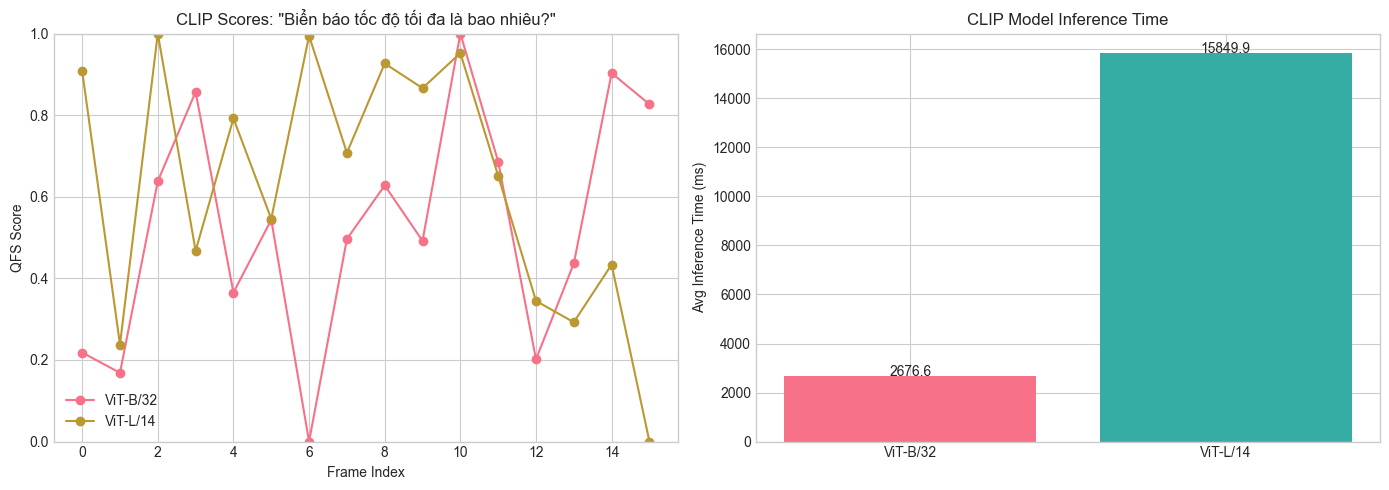

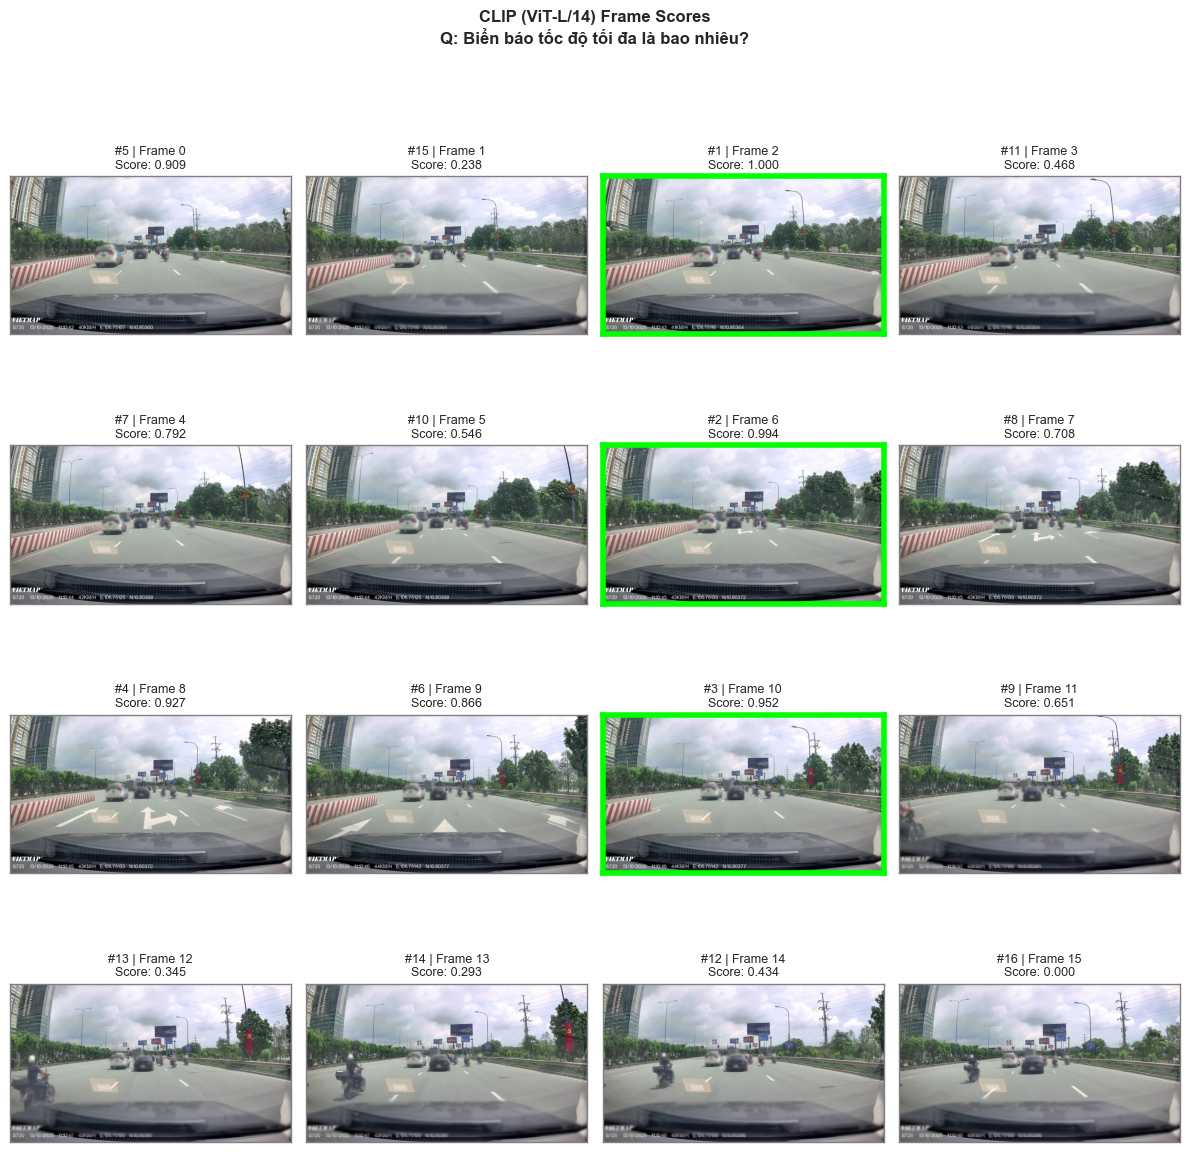

  Total frames: 16
  Score range: [0.000, 1.000]
  Mean score: 0.633 +- 0.301


In [66]:
if clip_results and any(r.success for r in clip_results):
    fig, axes = plt.subplots(1, 2, figsize=(14, 5))
    
    # Score distribution per model
    ax1 = axes[0]
    for result in clip_results:
        if result.success and len(result.scores) > 0:
            ax1.plot(range(len(result.scores)), result.scores, 
                     marker='o', label=result.model_name)
    ax1.set_xlabel('Frame Index')
    ax1.set_ylabel('QFS Score')
    ax1.set_title(f'CLIP Scores: "{TEST_QUESTIONS[0][:40]}"')
    ax1.legend()
    ax1.set_ylim(0, 1)
    
    # Timing comparison
    ax2 = axes[1]
    models = [r.model_name for r in clip_results if r.success]
    times = [r.avg_inference_ms for r in clip_results if r.success]
    colors = sns.color_palette('husl', len(models))
    bars = ax2.bar(models, times, color=colors)
    ax2.set_ylabel('Avg Inference Time (ms)')
    ax2.set_title('CLIP Model Inference Time')
    for bar, val in zip(bars, times):
        ax2.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 5, 
                 f'{val:.1f}', ha='center', fontsize=10)
    
    plt.tight_layout()
    plt.show()

    # Show all frames with scores
    visualize_frames_with_scores(
        frames=TEST_FRAMES,
        scores=result.scores,
        question=TEST_QUESTIONS[0],
        model_name=f"CLIP ({result.model_name})",
        cols=4,
        highlight_top=3,
        show_ranking=True
    )

## **2. Multilingual CLIP Benchmark**

Testing M-CLIP for direct Vietnamese support (no translation needed)

In [67]:
gc.collect()
mem_before = get_memory_mb()

try:
    init_start = time.perf_counter()
    mclip_scorer = MultilingualCLIPScoringStrategy(device="cpu")
    init_time = (time.perf_counter() - init_start) * 1000
    
    mem_after = get_memory_mb()
    memory_used = max(0.0, mem_after - mem_before)
    
    print(f"Init time: {init_time:.2f} ms")
    print(f"Memory: {memory_used:.1f} MB")
    
    # Benchmark
    start = time.perf_counter()
    scores = mclip_scorer.score(TEST_FRAMES, TEST_QUESTIONS[0])
    inference_time = (time.perf_counter() - start) * 1000
    
    result = BenchmarkResult(
        strategy_name="mclip",
        model_name="M-CLIP/XLM-Roberta-Large-Vit-L-14",
        init_time_ms=init_time,
        avg_inference_ms=inference_time,
        memory_mb=memory_used,
        avg_score=float(np.mean(scores)),
        scores=scores,
        success=True
    )
    all_results.append(result)
    
    print(f"Inference time: {inference_time:.2f} ms")
    print(f"Avg score: {np.mean(scores):.3f}")
    
except Exception as e:
    print(f"M-CLIP not available or error: {e}")
    all_results.append(BenchmarkResult(
        strategy_name="mclip",
        model_name="M-CLIP",
        success=False,
        error=str(e)
    ))

gc.collect()

Init time: 10320.88 ms
Memory: 100.4 MB
Inference time: 14096.49 ms
Avg score: 0.374


0

## **3. Detection Scoring Strategy Benchmark**

Testing YOLO-based detection boost with different models

In [68]:
YOLO_MODELS = [
    "yolo11n_unified",
    "yolo11l_unified",
]

detection_results = []

# Get target classes from question
analysis = analyzer.analyze(TEST_QUESTIONS[0])
target_classes = analysis.yolo_classes
print(f"\nTarget classes for '{TEST_QUESTIONS[0][:40]}...': {target_classes}")

for model_name in YOLO_MODELS:
    gc.collect()
    mem_before = get_memory_mb()
    
    try:
        # Check if model exists
        model_info = ModelRegistry.get_model_info(model_name)
        if not model_info or not model_info.exists:
            print(f"Model weights not found, skipping...")
            continue
        
        # Initialize
        init_start = time.perf_counter()
        yolo_model = get_model(model_name, device="cpu")
        scorer = DetectionScoringStrategy(confidence=0.25, device="cpu")
        scorer.set_model(yolo_model)
        init_time = (time.perf_counter() - init_start) * 1000
        
        mem_after = get_memory_mb()
        memory_used = max(0.0, mem_after - mem_before)
        
        print(f"  Init time: {init_time:.2f} ms")
        print(f"  Memory: {memory_used:.1f} MB")
        
        # Warmup
        _ = scorer.score(TEST_FRAMES[:2], TEST_QUESTIONS[0], target_classes)
        
        # Benchmark
        start = time.perf_counter()
        scores = scorer.score(TEST_FRAMES, TEST_QUESTIONS[0], target_classes)
        inference_time = (time.perf_counter() - start) * 1000
        
        result = BenchmarkResult(
            strategy_name="detection",
            model_name=model_name,
            init_time_ms=init_time,
            avg_inference_ms=inference_time,
            memory_mb=memory_used,
            avg_score=float(np.mean(scores)),
            score_std=float(np.std(scores)),
            min_score=float(np.min(scores)),
            max_score=float(np.max(scores)),
            scores=scores,
            success=True
        )
        detection_results.append(result)
        all_results.append(result)
        
        print(f"  Inference time: {inference_time:.2f} ms for {len(TEST_FRAMES)} frames")
        print(f"  Per-frame time: {inference_time/len(TEST_FRAMES):.2f} ms")
        print(f"  Avg detection score: {np.mean(scores):.3f}")
        print(f"  Frames with detections: {np.sum(scores > 0)} / {len(scores)}")
        
    except Exception as e:
        print(f"Error: {e}")
        detection_results.append(BenchmarkResult(
            strategy_name="detection",
            model_name=model_name,
            success=False,
            error=str(e)
        ))
    
    gc.collect()


Target classes for 'Biển báo tốc độ tối đa là bao nhiêu?...': ['traffic sign']
  Init time: 449.08 ms
  Memory: 0.0 MB
  Inference time: 856.92 ms for 16 frames
  Per-frame time: 53.56 ms
  Avg detection score: 0.700
  Frames with detections: 16 / 16
  Init time: 479.57 ms
  Memory: 70.9 MB
  Inference time: 7012.03 ms for 16 frames
  Per-frame time: 438.25 ms
  Avg detection score: 0.728
  Frames with detections: 16 / 16


## **4. Distinctiveness Strategy Benchmark**

Testing Inter-Frame Distinctiveness (IFD) scoring

In [69]:
WINDOW_SIZES = [1, 7, 15]

ifd_results = []

for window_size in WINDOW_SIZES:
    print(f"\nTesting window_size={window_size}")
    
    gc.collect()
    
    try:
        scorer = DistinctivenessStrategy(window_size=window_size)
        
        # Benchmark
        start = time.perf_counter()
        scores = scorer.compute_from_frames(TEST_FRAMES)
        inference_time = (time.perf_counter() - start) * 1000
        
        result = BenchmarkResult(
            strategy_name="distinctiveness",
            model_name=f"window={window_size}",
            init_time_ms=0.0,
            avg_inference_ms=inference_time,
            avg_score=float(np.mean(scores)),
            score_std=float(np.std(scores)),
            min_score=float(np.min(scores)),
            max_score=float(np.max(scores)),
            scores=scores,
            success=True
        )
        ifd_results.append(result)
        all_results.append(result)
        
        print(f"  Inference time: {inference_time:.3f} ms")
        print(f"  Avg distinctiveness: {np.mean(scores):.3f}")
        print(f"  Most distinct frame: {np.argmax(scores)} (score={np.max(scores):.3f})")
        
    except Exception as e:
        print(f"  Error: {e}")


Testing window_size=1
  Inference time: 100.967 ms
  Avg distinctiveness: 0.004
  Most distinct frame: 10 (score=0.006)

Testing window_size=7
  Inference time: 73.550 ms
  Avg distinctiveness: 0.010
  Most distinct frame: 8 (score=0.015)

Testing window_size=15
  Inference time: 63.969 ms
  Avg distinctiveness: 0.011
  Most distinct frame: 15 (score=0.015)


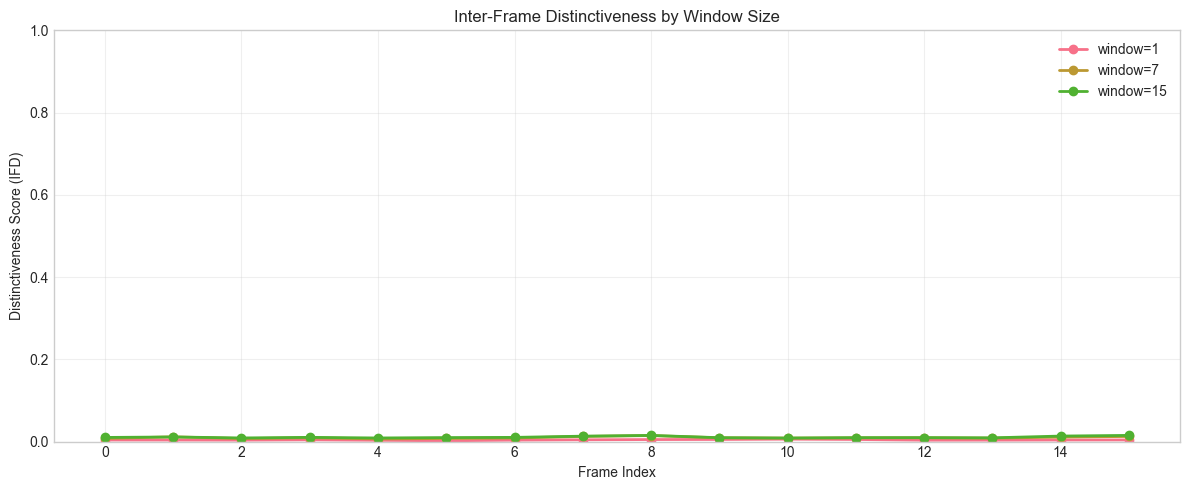

In [70]:
# Visualize distinctiveness scores
if ifd_results:
    fig, ax = plt.subplots(figsize=(12, 5))
    
    for result in ifd_results:
        ax.plot(range(len(result.scores)), result.scores, 
                marker='o', label=result.model_name, linewidth=2)
    
    ax.set_xlabel('Frame Index')
    ax.set_ylabel('Distinctiveness Score (IFD)')
    ax.set_title('Inter-Frame Distinctiveness by Window Size')
    ax.legend()
    ax.set_ylim(0, 1)
    ax.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()

## **5. Combined FrameScorer Benchmark**

In [71]:
# Different weight configurations to test
WEIGHT_CONFIGS = [
    {"name": "QFS Only", "alpha": 1.0, "beta": 0.0, "gamma": 0.0},
    {"name": "Balanced", "alpha": 0.5, "beta": 0.3, "gamma": 0.2},
    {"name": "Detection Focus", "alpha": 0.3, "beta": 0.5, "gamma": 0.2},
    {"name": "Diversity Focus", "alpha": 0.4, "beta": 0.2, "gamma": 0.4},
]

combined_results = []

for config in WEIGHT_CONFIGS:
    print(f"\n{'.'*60}")
    print(f"Testing: {config['name']} (α={config['alpha']}, β={config['beta']}, γ={config['gamma']})")
    print(f"{'.'*60}")
    
    gc.collect()
    mem_before = get_memory_mb()
    
    try:
        # Create scorer
        init_start = time.perf_counter()
        scorer = create_scorer(
            strategy="combined",
            clip_model="ViT-B/32",  # Use smaller model for combined tests
            device="cpu",
            use_translation=True,
            alpha=config['alpha'],
            beta=config['beta'],
            gamma=config['gamma']
        )
        
        # Set YOLO model if detection is enabled
        if config['beta'] > 0:
            try:
                yolo_model = get_model("yolo11n_unified", device="cpu")
                scorer.set_yolo_model(yolo_model)
            except:
                print("  YOLO model not available, detection scoring disabled")
        
        init_time = (time.perf_counter() - init_start) * 1000
        mem_after = get_memory_mb()
        
        print(f"  Init time: {init_time:.2f} ms")
        print(f"  Memory: {mem_after - mem_before:.1f} MB")
        
        # Get target classes
        analysis = analyzer.analyze(TEST_QUESTIONS[0])
        
        # Benchmark with detailed scores
        start = time.perf_counter()
        detailed_scores = scorer.score_frames(
            TEST_FRAMES, 
            TEST_QUESTIONS[0], 
            target_classes=analysis.yolo_classes,
            return_detailed=True
        )
        inference_time = (time.perf_counter() - start) * 1000
        
        final_scores = np.array([s.final_score for s in detailed_scores])
        qfs_scores = np.array([s.qfs_score for s in detailed_scores])
        det_scores = np.array([s.detection_score for s in detailed_scores])
        ifd_scores = np.array([s.ifd_score for s in detailed_scores])
        
        result = BenchmarkResult(
            strategy_name="combined",
            model_name=config['name'],
            init_time_ms=init_time,
            avg_inference_ms=inference_time,
            memory_mb=max(0.0, mem_after - mem_before),
            avg_score=float(np.mean(final_scores)),
            score_std=float(np.std(final_scores)),
            min_score=float(np.min(final_scores)),
            max_score=float(np.max(final_scores)),
            scores=final_scores,
            success=True
        )
        combined_results.append(result)
        all_results.append(result)
        
        print(f"  Inference time: {inference_time:.2f} ms")
        print(f"  Score breakdown:")
        print(f"    QFS mean: {np.mean(qfs_scores):.3f}")
        print(f"    Detection mean: {np.mean(det_scores):.3f}")
        print(f"    IFD mean: {np.mean(ifd_scores):.3f}")
        print(f"    Final mean: {np.mean(final_scores):.3f}")
        print(f"  Top frame: {np.argmax(final_scores)} (score={np.max(final_scores):.3f})")
        
    except Exception as e:
        print(f"  Error: {e}")
        import traceback
        traceback.print_exc()
    
    gc.collect()


............................................................
Testing: QFS Only (α=1.0, β=0.0, γ=0.0)
............................................................
  Init time: 3994.62 ms
  Memory: 349.9 MB
  Inference time: 3885.60 ms
  Score breakdown:
    QFS mean: 0.529
    Detection mean: 0.000
    IFD mean: 0.000
    Final mean: 0.529
  Top frame: 10 (score=1.000)

............................................................
Testing: Balanced (α=0.5, β=0.3, γ=0.2)
............................................................
  Init time: 3185.38 ms
  Memory: 84.2 MB
  Inference time: 3436.44 ms
  Score breakdown:
    QFS mean: 0.529
    Detection mean: 0.700
    IFD mean: 0.006
    Final mean: 0.476
  Top frame: 10 (score=0.782)

............................................................
Testing: Detection Focus (α=0.3, β=0.5, γ=0.2)
............................................................
  Init time: 2624.82 ms
  Memory: -332.2 MB
  Inference time: 4671.94 ms
  Score breakd

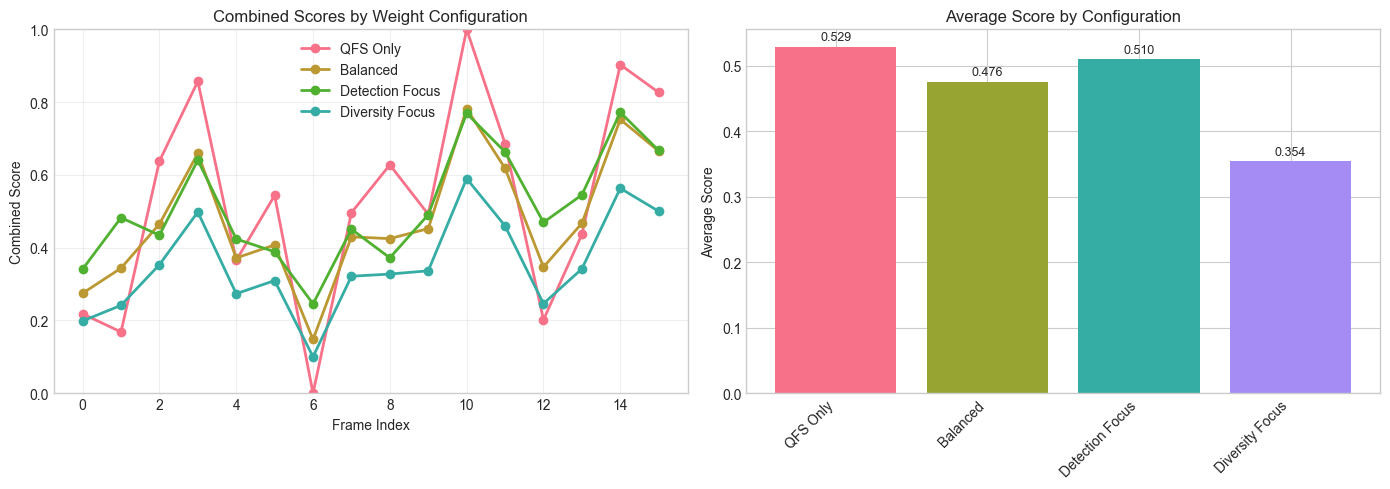

In [72]:
# Visualize combined scores
if combined_results:
    fig, axes = plt.subplots(1, 2, figsize=(14, 5))
    
    # Score distribution per configuration
    ax1 = axes[0]
    for result in combined_results:
        ax1.plot(range(len(result.scores)), result.scores, 
                 marker='o', label=result.model_name, linewidth=2)
    ax1.set_xlabel('Frame Index')
    ax1.set_ylabel('Combined Score')
    ax1.set_title('Combined Scores by Weight Configuration')
    ax1.legend()
    ax1.set_ylim(0, 1)
    ax1.grid(True, alpha=0.3)
    
    # Bar chart of average scores
    ax2 = axes[1]
    names = [r.model_name for r in combined_results]
    avgs = [r.avg_score for r in combined_results]
    colors = sns.color_palette('husl', len(names))
    bars = ax2.bar(range(len(names)), avgs, color=colors)
    ax2.set_xticks(range(len(names)))
    ax2.set_xticklabels(names, rotation=45, ha='right')
    ax2.set_ylabel('Average Score')
    ax2.set_title('Average Score by Configuration')
    for bar, val in zip(bars, avgs):
        ax2.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01, 
                 f'{val:.3f}', ha='center', fontsize=9)
    
    plt.tight_layout()
    plt.show()

## **6. Complete Results Comparison**

In [73]:
# Create summary dataframe
summary_data = []
for r in all_results:
    summary_data.append({
        "Strategy": r.strategy_name,
        "Model/Config": r.model_name,
        "Init Time (ms)": f"{r.init_time_ms:.1f}",
        "Inference (ms)": f"{r.avg_inference_ms:.1f}",
        "Memory (MB)": f"{r.memory_mb:.1f}",
        "Avg Score": f"{r.avg_score:.3f}",
        "Score Std": f"{r.score_std:.3f}" if r.score_std > 0 else "-",
    })

df_summary = pd.DataFrame(summary_data)
display(df_summary)

,Strategy,Model/Config,Init Time (ms),Inference (ms),Memory (MB),Avg Score,Score Std
0,clip,ViT-B/32,2312.4,2676.6,2.0,0.475,0.065
1,clip,ViT-L/14,11924.7,15849.9,0.0,0.441,0.112
2,mclip,M-CLIP/XLM-Roberta-Large-Vit-L-14,10320.9,14096.5,100.4,0.374,-
3,detection,yolo11n_unified,449.1,856.9,0.0,0.700,0.189
4,detection,yolo11l_unified,479.6,7012.0,70.9,0.728,0.148
5,distinctiveness,window=1,0.0,101.0,0.0,0.004,0.001
6,distinctiveness,window=7,0.0,73.6,0.0,0.010,0.002
7,distinctiveness,window=15,0.0,64.0,0.0,0.011,0.002
8,combined,QFS Only,3994.6,3885.6,349.9,0.529,0.280
9,combined,Balanced,3185.4,3436.4,84.2,0.476,0.170


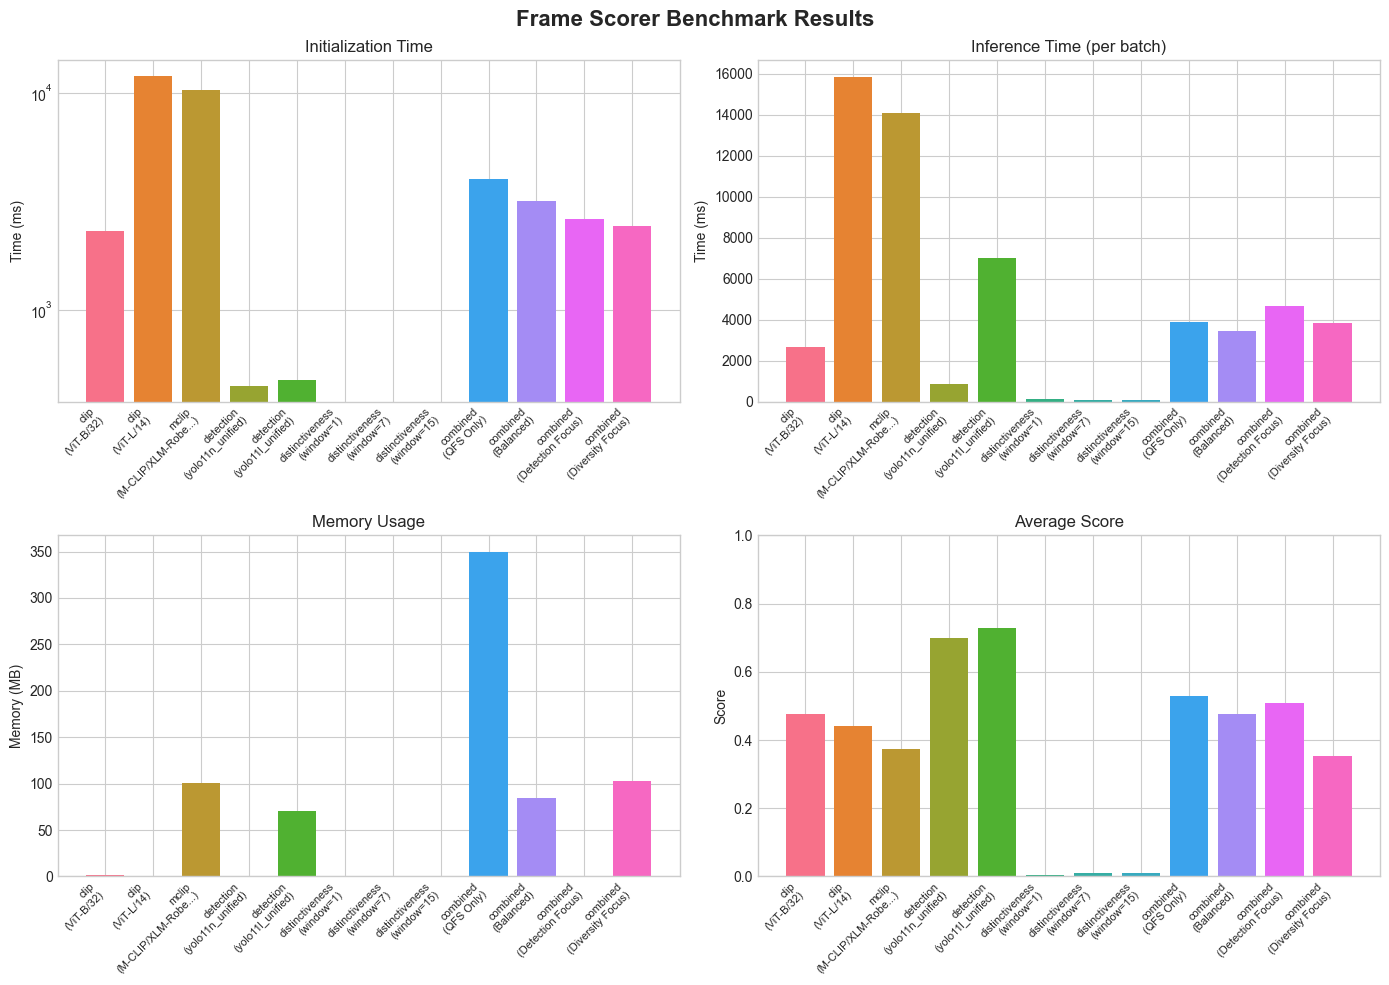

In [74]:
# Grand visualization
successful_results = [r for r in all_results if r.success]

if successful_results:
    fig, axes = plt.subplots(2, 2, figsize=(14, 10))
    fig.suptitle('Frame Scorer Benchmark Results', fontsize=16, fontweight='bold')
    
    labels = [f"{r.strategy_name}\n({r.model_name[:15]}...)" if len(r.model_name) > 15
              else f"{r.strategy_name}\n({r.model_name})" for r in successful_results]
    colors = sns.color_palette('husl', len(successful_results))
    
    # 1. Init Time
    ax1 = axes[0, 0]
    init_times = [r.init_time_ms for r in successful_results]
    bars = ax1.bar(range(len(successful_results)), init_times, color=colors)
    ax1.set_xticks(range(len(successful_results)))
    ax1.set_xticklabels(labels, rotation=45, ha='right', fontsize=8)
    ax1.set_ylabel('Time (ms)')
    ax1.set_title('Initialization Time')
    ax1.set_yscale('log')
    
    # 2. Inference Time
    ax2 = axes[0, 1]
    inf_times = [r.avg_inference_ms for r in successful_results]
    bars = ax2.bar(range(len(successful_results)), inf_times, color=colors)
    ax2.set_xticks(range(len(successful_results)))
    ax2.set_xticklabels(labels, rotation=45, ha='right', fontsize=8)
    ax2.set_ylabel('Time (ms)')
    ax2.set_title('Inference Time (per batch)')
    
    # 3. Memory Usage
    ax3 = axes[1, 0]
    memory = [r.memory_mb for r in successful_results]
    bars = ax3.bar(range(len(successful_results)), memory, color=colors)
    ax3.set_xticks(range(len(successful_results)))
    ax3.set_xticklabels(labels, rotation=45, ha='right', fontsize=8)
    ax3.set_ylabel('Memory (MB)')
    ax3.set_title('Memory Usage')
    
    # 4. Average Score
    ax4 = axes[1, 1]
    avg_scores = [r.avg_score for r in successful_results]
    bars = ax4.bar(range(len(successful_results)), avg_scores, color=colors)
    ax4.set_xticks(range(len(successful_results)))
    ax4.set_xticklabels(labels, rotation=45, ha='right', fontsize=8)
    ax4.set_ylabel('Score')
    ax4.set_title('Average Score')
    ax4.set_ylim(0, 1)
    
    plt.tight_layout()
    plt.savefig('./outputs/frame_scorer_benchmark.png', dpi=150, bbox_inches='tight')
    plt.show()

In [75]:
# Export to CSV
export_data = []
for r in all_results:
    export_data.append({
        "strategy": r.strategy_name,
        "model": r.model_name,
        "init_time_ms": r.init_time_ms,
        "avg_inference_ms": r.avg_inference_ms,
        "memory_mb": r.memory_mb,
        "avg_score": r.avg_score,
        "score_std": r.score_std,
        "min_score": r.min_score,
        "max_score": r.max_score,
        "success": r.success,
        "error": r.error
    })

export_df = pd.DataFrame(export_data)
export_df.to_csv('./outputs/frame_scorer_benchmark.csv', index=False)

print(f"\nTotal strategies tested: {len(all_results)}")
print(f"Successful: {len([r for r in all_results if r.success])}")
print(f"Failed: {len([r for r in all_results if not r.success])}")


Total strategies tested: 12
Successful: 12
Failed: 0
